# Developing Predictive Modelling for Regression & Clustering 

In [161]:
# Import Necessary Modules
import pandas as pd 
import numpy as np 
import warnings
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, roc_auc_score, recall_score,confusion_matrix, ConfusionMatrixDisplay 
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

pd.set_option('display.max_columns', 500)
warnings.filterwarnings('ignore')

## Data Preparation

In [162]:
# call all dataset 
customer = pd.read_csv(r'D:/Rakamin Academy/Job Accelaration Program (JAP)/VIX Data Scientist at Kalbe/Final Project/Dataset/Case Study - Customer.csv',delimiter = ';')
product = pd.read_csv(r'D:/Rakamin Academy/Job Accelaration Program (JAP)/VIX Data Scientist at Kalbe/Final Project/Dataset/Case Study - Product.csv',delimiter = ';')
store = pd.read_csv(r'D:/Rakamin Academy/Job Accelaration Program (JAP)/VIX Data Scientist at Kalbe/Final Project/Dataset/Case Study - Store.csv',delimiter = ';')
transaction = pd.read_csv(r'D:/Rakamin Academy/Job Accelaration Program (JAP)/VIX Data Scientist at Kalbe/Final Project/Dataset/Case Study - Transaction.csv',delimiter = ';')

In [163]:
# Perform data merging into one dataframe
cust_transac = pd.merge(transaction, customer, how = 'inner', on  = 'CustomerID')
cust_transac_product = pd.merge(cust_transac, product, how = 'inner', on ='ProductID')
df = pd.merge(cust_transac_product, store, how = 'inner', on = 'StoreID')
df.head()

,TransactionID,CustomerID,Date,ProductID,Price_x,Qty,TotalAmount,StoreID,Age,Gender,Marital Status,Income,Product Name,Price_y,StoreName,GroupStore,Type,Latitude,Longitude
0,TR11369,328,01/01/2022,P3,7500,4,30000,12,36,0,Married,"10,53",Crackers,7500,Prestasi Utama,Prestasi,General Trade,"-2,990934","104,756554"
1,TR89318,183,17/07/2022,P3,7500,1,7500,12,27,1,Single,"0,18",Crackers,7500,Prestasi Utama,Prestasi,General Trade,"-2,990934","104,756554"
2,TR9106,123,26/09/2022,P3,7500,4,30000,12,34,0,Married,"4,36",Crackers,7500,Prestasi Utama,Prestasi,General Trade,"-2,990934","104,756554"
3,TR4331,335,08/01/2022,P3,7500,3,22500,12,29,1,Single,"4,74",Crackers,7500,Prestasi Utama,Prestasi,General Trade,"-2,990934","104,756554"
4,TR6445,181,10/01/2022,P3,7500,4,30000,12,33,1,Married,"9,94",Crackers,7500,Prestasi Utama,Prestasi,General Trade,"-2,990934","104,756554"


In [164]:
# check dataset basic information
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5020 entries, 0 to 5019
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   TransactionID   5020 non-null   object
 1   CustomerID      5020 non-null   int64 
 2   Date            5020 non-null   object
 3   ProductID       5020 non-null   object
 4   Price_x         5020 non-null   int64 
 5   Qty             5020 non-null   int64 
 6   TotalAmount     5020 non-null   int64 
 7   StoreID         5020 non-null   int64 
 8   Age             5020 non-null   int64 
 9   Gender          5020 non-null   int64 
 10  Marital Status  4976 non-null   object
 11  Income          5020 non-null   object
 12  Product Name    5020 non-null   object
 13  Price_y         5020 non-null   int64 
 14  StoreName       5020 non-null   object
 15  GroupStore      5020 non-null   object
 16  Type            5020 non-null   object
 17  Latitude        5020 non-null   object
 18  Longitud

In [165]:
# check descriptive statistics
df.describe().T

,count,mean,std,min,25%,50%,75%,max
CustomerID,5020.0,221.263745,129.672955,1.0,108.0,221.0,332.0,447.0
Price_x,5020.0,9684.800797,4600.708780,3200.0,4200.0,9400.0,15000.0,18000.0
Qty,5020.0,3.644622,1.855295,1.0,2.0,3.0,5.0,10.0
TotalAmount,5020.0,32279.482072,19675.462455,7500.0,16000.0,28200.0,47000.0,88000.0
StoreID,5020.0,7.489841,4.028502,1.0,4.0,7.0,11.0,14.0
Age,5020.0,40.003586,12.834719,0.0,30.0,39.0,51.0,72.0
Gender,5020.0,0.452988,0.497835,0.0,0.0,0.0,1.0,1.0
Price_y,5020.0,9684.800797,4600.708780,3200.0,4200.0,9400.0,15000.0,18000.0


In [166]:
# Fill the missing values with modus
df['Marital Status'] = df['Marital Status'].fillna(df['Marital Status'].mode()[0])

# Transform date feature into datetime object 
df['Date'] = pd.to_datetime(df['Date'].str.strip(), format = '%d/%m/%Y' )

## Forecast Daily Total Quantity Using ARIMA Method 

In [167]:
# order data position by the date
df = df.sort_values('Date', ascending = True)
df.head()

,TransactionID,CustomerID,Date,ProductID,Price_x,Qty,TotalAmount,StoreID,Age,Gender,Marital Status,Income,Product Name,Price_y,StoreName,GroupStore,Type,Latitude,Longitude
0,TR11369,328,2022-01-01,P3,7500,4,30000,12,36,0,Married,"10,53",Crackers,7500,Prestasi Utama,Prestasi,General Trade,"-2,990934","104,756554"
4814,TR35256,160,2022-01-01,P1,8800,7,61600,4,48,1,Married,"12,57",Choco Bar,8800,Gita Ginara,Gita,General Trade,"-6,966667","110,416664"
337,TR76340,287,2022-01-01,P4,12000,4,48000,12,36,0,Single,"3,7",Potato Chip,12000,Prestasi Utama,Prestasi,General Trade,"-2,990934","104,756554"
3042,TR7596,270,2022-01-01,P7,9400,2,18800,14,49,1,Married,"8,81",Coffee Candy,9400,Priangan,Priangan,Modern Trade,"-5,45","105,26667"
3288,TR54287,51,2022-01-01,P8,16000,2,32000,2,36,0,Married,"7,95",Oat,16000,Prima Kelapa Dua,Prima,Modern Trade,"-6,914864","107,608238"


<AxesSubplot: >

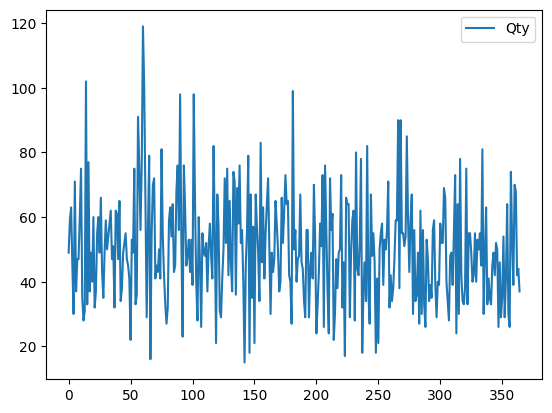

In [168]:
# check data stationary
qty.plot()

- The data seems has constant values of variance. It should fullfill ARIMA assumptions where time-series data need to have constant value of variance
- We can try to use log transformation to create time-series data of daily total quantity "more constant of variance"

In [169]:
# Extract Qty Values 
qty = df.groupby('Date')['Qty'].sum().reset_index()
qty = qty.drop('Date', axis=1)

In [170]:
# Create train & test : 80% train data & 20% test data
split_index = int(0.8 * len(qty))
qty_train = qty.iloc[:split_index] 
qty_test = qty.iloc[split_index:]

- After performing log transformation, the data seems have more constant variance. But the results seems not so different with the data without log transformation 
- Besides using plotting method, we also could use ACF & PACF method and statistical test to verify time-series data has constant variations

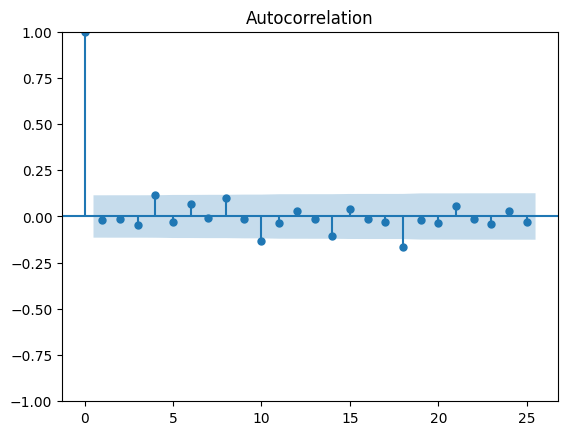

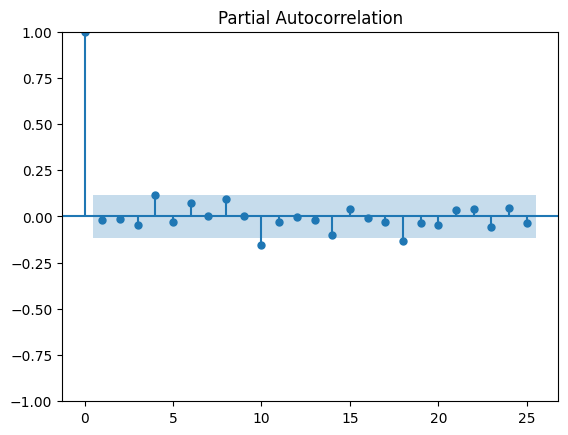

In [171]:
# Test stationary of data using ACF & PACF
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

acf_original = plot_acf(qty_train)

pacf_original = plot_pacf(qty_train)

In [172]:
# Test stationary of data using statistical methods : ADF
from statsmodels.tsa.stattools import adfuller

adf_test = adfuller(qty_train)
print('P Values : {:30f}'.format(adf_test[1]))

P Values :                       0.000000


- The Null Hypothesis "The Data Is Not Stationary", with p value < 0.05 and sig test 95%, we could say that null hypothesis is rejected.
- Meaning the data with ADF test is stationary. The data was fulfilled assumptions for performing ARIMA forecasting
- ARIMA will be using parameter I = 1 

### Determine ARIMA parameters p, q
Some considerations that could help determining p & q values (sources : [Youtube](https://www.youtube.com/watch?v=-aCF0_wfVwY)): 
- If the PACF plot has a significant spike at lag p, but not beyond. The ACF plot decays more gradually. This may suggest an ARIMA (p, d, 0) model.
- if the ACF plot has a significant spike at lag q, but not beyond. the PACF plot decays more gradually. This may suggest an ARIMA (0, d, q) mode.

From PACF and ACF plot we created above, it seems that we have time-series data that not fullfill either one of the two criteria. We will performing grid-search that could find p & q values that give best performances

In [173]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
import numpy as np
from statsmodels.tsa.arima.model import ARIMA

# Define a range of values to experiment with for 'p' and 'q'
p_values = range(0, 4)  # Replace with your desired range
q_values = range(0, 4)  # Replace with your desired range

best_mae = float('inf')  # Initialize with a large value
best_mape = float('inf')
best_rmse = float('inf')
best_p = 0
best_q = 0

for p in p_values:
    for q in q_values:
        # Fit the ARIMA model with the current 'p' and 'q' values
        model = ARIMA(qty_train, order=(p, 1, q))  # Modify 'd' if needed
        model_fit = model.fit()
        predicted_values = model_fit.forecast(len(qty_test))

        # Calculate evaluation metrics for the current 'p' and 'q' values
        mae = mean_absolute_error(qty_test, predicted_values)
        mape = mean_absolute_percentage_error(qty_test, predicted_values)
        rmse = np.sqrt(mean_squared_error(qty_test, predicted_values))

        # Check if this combination yields better results
        if mae < best_mae:
            best_mae = mae
            best_p = p
            best_q = q

        if mape < best_mape:
            best_mape = mape
            best_p = p
            best_q = q

        if rmse < best_rmse:
            best_rmse = rmse
            best_p = p
            best_q = q

# Print the best combination of 'p' and 'q' and their corresponding metrics
print("Best 'p' value: {}".format(best_p))
print("Best 'q' value: {}".format(best_q))
print("Best MAE: {:.4f}".format(best_mae))
print("Best MAPE: {:.4f}%".format(best_mape * 100))
print("Best RMSE: {:.4f}".format(best_rmse))

Best 'p' value: 3
Best 'q' value: 3
Best MAE: 11.4186
Best MAPE: 23.5681%
Best RMSE: 13.9539


In [174]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
import numpy as np
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(qty_train, order=(3,1,0))
model_fit = model.fit()
predicted_values = model_fit.forecast(len(qty_test))

mae = mean_absolute_error(qty_test, predicted_values)
mape = mean_absolute_percentage_error(qty_test, predicted_values)
rmse = np.sqrt(mean_squared_error(qty_test, predicted_values))

# Print the evaluation metrics
print("MAE: {:.4f}".format(mae))
print("MAPE: {:.4f}%".format(mape * 100))
print("RMSE: {:.4f}".format(rmse))

MAE: 11.5451
MAPE: 23.5681%
RMSE: 15.0872


In [175]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
import numpy as np
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(qty_train, order=(0,1,3))
model_fit = model.fit()
predicted_values = model_fit.forecast(len(qty_test))

mae = mean_absolute_error(qty_test, predicted_values)
mape = mean_absolute_percentage_error(qty_test, predicted_values)
rmse = np.sqrt(mean_squared_error(qty_test, predicted_values))

# Print the evaluation metrics
print("MAE: {:.4f}".format(mae))
print("MAPE: {:.4f}%".format(mape * 100))
print("RMSE: {:.4f}".format(rmse))

MAE: 11.8497
MAPE: 29.2975%
RMSE: 14.1485


- Comparing using p = 3 and q = 3 on ARIMA models, it seem there is no significant difference between the two of them
- model performance using p=3 seems relatively give better performance. we will use that parameter to predict new ocurrence for the next 365 days

### Predict for the Next 365 days 

In [187]:
from statsmodels.tsa.arima.model import ARIMA

# Forecast for the next 365 days
forecast_horizon = 365
forecast = model_fit.forecast(steps=forecast_horizon)

# Access the forecasted values
print(forecast)

292    50.086532
293    49.877311
294    49.670956
295    49.670956
296    49.670956
         ...    
652    49.670956
653    49.670956
654    49.670956
655    49.670956
656    49.670956
Name: predicted_mean, Length: 365, dtype: float64


In [177]:
# Transform predicted data into excels 
forecast.to_csv('Next Year Forecasting.csv')

## Perform Clustering 

In [178]:
# Perform Aggregation Based on CustomerID toward Quantity & Amount
cluster = df.groupby('CustomerID')['Qty', 'TotalAmount'].sum().reset_index()
cluster_scaled = cluster.drop('CustomerID', axis=1)

In [179]:
# Perform normalization on Qty & Total Amount feature
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

cluster_scaled = pd.DataFrame(scaler.fit_transform(cluster_scaled), columns = cluster_scaled.columns )
cluster_scaled.head()

,Qty,TotalAmount
0,0.724638,0.703949
1,0.681159,0.397827
2,0.666667,0.469255
3,0.521739,0.278823
4,0.246377,0.233899


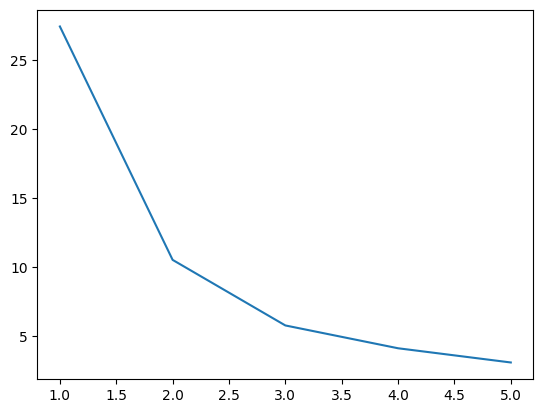

In [180]:
# Elbow Method
from sklearn.cluster import KMeans

inertia = []
for i in range(1,6):
    kmeans = KMeans(n_clusters=i , random_state=0)
    kmeans.fit(cluster_scaled)
    inertia.append(kmeans.inertia_)

# Elbow plot
plt.plot(range(1,6),inertia)
plt.show()

In [181]:
# Fitting clustering model using KMeans Clustering 
from sklearn.metrics import silhouette_score

kmeans = KMeans(n_clusters=3, random_state = 42).fit(cluster_scaled)
preds = kmeans.predict(cluster_scaled)

cluster_scaled['Cluster'] = kmeans.labels_

# Mengevaluasi pengkluseran menggunakan Silhoutte Score
silhouette_score(cluster_scaled, preds, metric='euclidean')

0.8744519957516692

- As closer the silhoutte score to 1, meaning the better model performance to clusterize. Otherwise, the model could differentiate between cluster with lesser overlap
- We have silhoutte score 86.7. Meaning we have relatively good model performance. We could use this model to perform clusterization

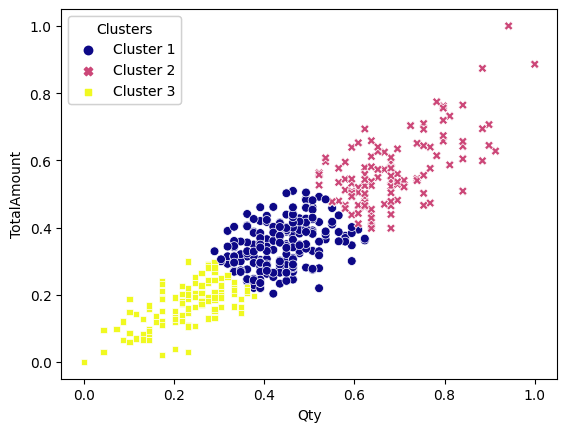

In [182]:
fig = plt.figure()

x = cluster_scaled['Qty']
y = cluster_scaled['TotalAmount']

# Scatter plot with cluster coloring
scatter = sns.scatterplot(x=x, y=y, hue=cluster_scaled["Cluster"], style=cluster_scaled["Cluster"], s=40, palette="plasma")

# Create a legend
cluster_labels = ['Cluster 1', 'Cluster 2', 'Cluster 3']
handles, _ = scatter.get_legend_handles_labels()
legend = plt.legend(handles=handles, labels=cluster_labels, title="Clusters")
fig.add_artist(legend)

plt.show()

The results from plotting above shows that we have clusterize with good separation

In [183]:
# Put the cluster into the dataframe
df['Cluster'] = cluster_scaled['Cluster']
df['Cluster'] = df['Cluster'].fillna(0.0)
df.head()

,TransactionID,CustomerID,Date,ProductID,Price_x,Qty,TotalAmount,StoreID,Age,Gender,Marital Status,Income,Product Name,Price_y,StoreName,GroupStore,Type,Latitude,Longitude,Cluster
0,TR11369,328,2022-01-01,P3,7500,4,30000,12,36,0,Married,"10,53",Crackers,7500,Prestasi Utama,Prestasi,General Trade,"-2,990934","104,756554",1.0
4814,TR35256,160,2022-01-01,P1,8800,7,61600,4,48,1,Married,"12,57",Choco Bar,8800,Gita Ginara,Gita,General Trade,"-6,966667","110,416664",0.0
337,TR76340,287,2022-01-01,P4,12000,4,48000,12,36,0,Single,"3,7",Potato Chip,12000,Prestasi Utama,Prestasi,General Trade,"-2,990934","104,756554",0.0
3042,TR7596,270,2022-01-01,P7,9400,2,18800,14,49,1,Married,"8,81",Coffee Candy,9400,Priangan,Priangan,Modern Trade,"-5,45","105,26667",0.0
3288,TR54287,51,2022-01-01,P8,16000,2,32000,2,36,0,Married,"7,95",Oat,16000,Prima Kelapa Dua,Prima,Modern Trade,"-6,914864","107,608238",0.0


In [184]:
# Transform clusterized data into csv
df.to_csv('Clusterized Data.csv')